In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torchvision.datasets as D
import torch.nn.functional as F
import numpy as np
import pickle
from matplotlib import pyplot as plt
import sys
sys.path.append("..")
from utils.utils import MyDataset, show_image, visualise_output
from networks.autoencoder import FireAutoencoder
from networks.autoencoder_reward import FireAutoencoder_reward
import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import scipy
from torch.autograd import Variable 

In [2]:
train_dataset = MyDataset(root='../../data/complete_random/homo_2/Sub20x20_full_grid_.pkl',
                             tform=lambda x: torch.from_numpy(x, dtype=torch.float
))

In [62]:
latent_dims = 128
capacity = latent_dims//2 
input_size = 20
epochs = 100
sigmoid = False
net = FireAutoencoder_reward(capacity, input_size, latent_dims, sigmoid)
net.load_state_dict(torch.load(f'../weights/AE_Reward/homo_2_sub20x20_latent={latent_dims}_capacity={capacity}_{epochs}_sigmoid={sigmoid}.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [63]:
full_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)

In [64]:
all_images, all_r = next(iter(full_loader))

In [65]:
embeddings = net.encode(all_images)

In [66]:
net.decode(embeddings)[0]

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],

In [67]:
with torch.no_grad():
    rewards = net.predict_reward(embeddings)

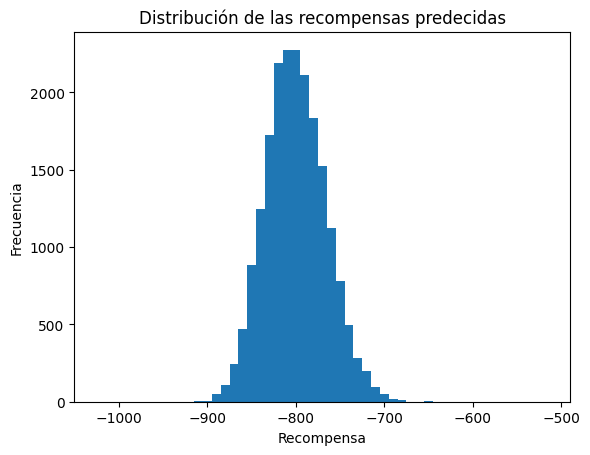

In [68]:
bins = np.arange(-1020, -500, 10)
plt.hist(rewards.numpy(), bins=bins, align='left')
plt.title('Distribución de las recompensas predecidas')
plt.xlabel('Recompensa')
plt.ylabel('Frecuencia')
#plt.savefig(f"linear_regresion/reward_classes_distr_{latent_dims}_{epochs}_sigmoid={sigmoid}.png.png")
plt.show()

In [69]:
minimum = Variable(torch.zeros(1, latent_dims), requires_grad=True) 

In [70]:
optimizer = torch.optim.Adam([minimum], lr = 0.001)

In [71]:
for i in range(10000):
    my_single_scalar = -net.predict_reward(minimum[0])
    optimizer.zero_grad()
    my_single_scalar.backward()
    optimizer.step()

In [72]:
net.float()

FireAutoencoder_reward(
  (conv1): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc): Linear(in_features=3200, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=3200, bias=True)
  (conv1_2): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_2): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (fc_r1): Linear(in_features=128, out_features=128, bias=True)
  (fc_r2): Linear(in_features=128, out_features=64, bias=True)
  (fc_r3): Linear(in_features=64, out_features=32, bias=True)
  (fc_r4): Linear(in_features=32, out_features=1, bias=True)
  (criterion_1): MSELoss()
  (criterion_2): MSELoss()
)

In [73]:
solution = net.decode(minimum.float().unsqueeze(0))

In [74]:
solution

tensor([[[[0.4454, 0.0099, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 2.4835,
           0.0000, 0.0000, 0.0413, 0.0000, 0.0000, 1.3790, 0.0000, 0.0000,
           0.0000, 3.5609, 0.0000, 1.2016],
          [0.0000, 0.8590, 0.0000, 0.1401, 0.0000, 1.4239, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 1.8938, 0.0000, 0.0000, 0.0000, 0.0000,
           1.9485, 0.2824, 0.0000, 0.0000],
          [1.0107, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           1.4884, 1.5904, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.6753],
          [0.0000, 3.4532, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.5831, 1.8555, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 3.5963, 0.0000, 0.0000],
          [5.0933, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0

In [75]:
if sigmoid:
    solution[solution>=0.5] = 1
    solution[solution<=0.5] = 0
else:
    solution[solution>0] = 1

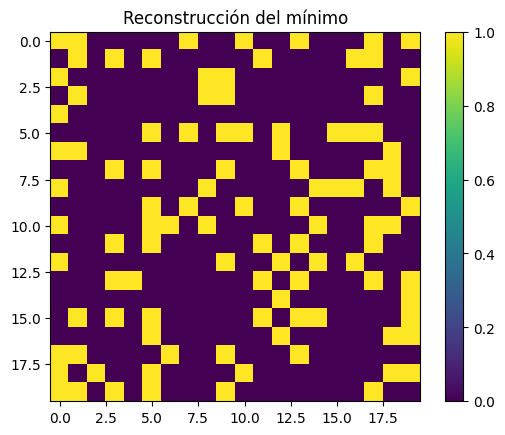

In [76]:
with torch.no_grad():
        plt.title('Reconstrucción del mínimo')
        plt.imshow(solution[0][0].numpy())
        plt.savefig(f"linear_regresion/AE_Reward/minimum_decoding_{latent_dims}_{epochs}_sigmoid={sigmoid}.png")
        plt.colorbar()
        plt.show()

In [77]:
with torch.no_grad():
    print(repr(solution[0][0].numpy()))

array([[1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 1.],
       [0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        1., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1.,
        1., 1., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
        0., 1., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 1.,
        1., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 1.